In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
import scipy.stats as st
from scipy.optimize import brentq

Assuming a string model of binary spins of length $L$, we consider the target antigen as a string of zeros, and the repertoire is composed of $N\approx 10^7$ random strings.
The probability for a receptor of having Hamming distance equal to $H$ is a binomial distribtuion:
$$
H \sim \text{Binom} \left( L, \frac{1}{2} \right) \
$$

The recruitment probability is then defined as:
$$
p_{\rm recr}(H) = \exp \left[ - \left( H/D_0 \right)^\gamma \right] 
$$

The average probability of being recruted reads
$$
\langle p_{\rm recr} \rangle = \sum_H \text{Binom} \left( L, \frac{1}{2} \right) p(H)_{\rm recr} = 2^{-L} \sum_H \binom{L}{H} \exp \left[ - \left( H/D_0 \right)^\gamma \right]
$$

We want to find numerically $D_0$ that leads to a given $\langle p \rangle$

In [33]:
def av_p_recr(D0, L, gamma):
    s = np.sum([binom(L,H) * np.exp(-(H/D0)**gamma) for H in range(L+1)])
    return s*2**(-L)

def w_pass(H, D0, L, gamma):
    return binom(L,H) * np.exp(-(H/D0)**gamma)

def mean_std_h_pass(D0, L, gamma):
    Hs = np.arange(L+1)
    wh = w_pass(Hs, D0, L, gamma)
    mean = np.sum(wh * Hs) / np.sum(wh)
    m2 = np.sum(wh * Hs**2) / np.sum(wh)
    return mean, np.sqrt(m2 - mean**2)

In [8]:
av_p_recr(5, 20, 1), av_p_recr(0.01, 20, 1)

(np.float64(0.1495437594594227), np.float64(9.5367431640625e-07))

In [19]:
L, N_tots = 20, np.array([10**5, 10**6, 10**7])
N_recruit = 100
R = 200

D0s1 = [brentq(lambda x : av_p_recr(x, L, 1) - N_recruit/N, 0.01, 5) for N in N_tots]
D0s2 = [brentq(lambda x : av_p_recr(x, L, 2) - N_recruit/N, 0.01, 5) for N in N_tots]

h_recruit_post1, h_recruit_post2 = [], []
for r in range(R):

    h_aux1, h_aux2 = [], []
    for i, N_tot in enumerate(N_tots):
    
        # Generating hamming distances
        h_dists = st.binom(L, 0.5).rvs(N_tot)
        
        # Computin prob with gamma = 1 and gamma = 2
        recruit_prob1 = np.exp(-h_dists/D0s1[i])
        recruit_prob2 = np.exp(-(h_dists/D0s2[i])**2)
        
        # Selecting the clonotypes according to their recruitment prob
        unifs = np.random.rand(N_tot)
        h_recruit1 = h_dists[unifs < recruit_prob1]
        h_recruit2 = h_dists[unifs < recruit_prob2]
    
        h_aux1.append(h_recruit1)
        h_aux2.append(h_recruit2)

    h_recruit_post1.append(h_aux1)
    h_recruit_post2.append(h_aux2)
    print(r, end='\r', flush=True)

199

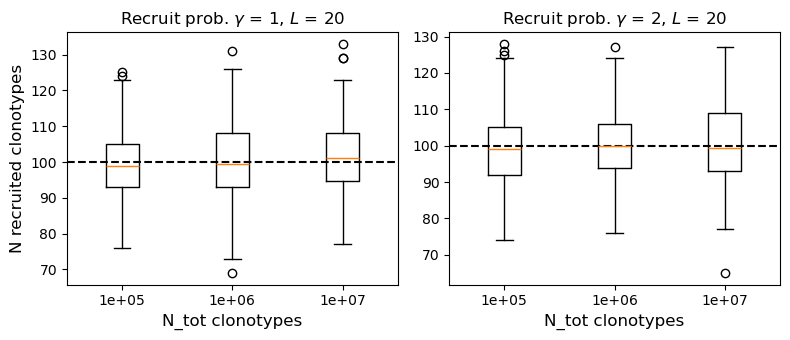

In [20]:
N_recruit_posts1, N_recruit_posts2 = [], []
for i, N_tot in enumerate(N_tots):
    N_recruit_posts1.append([len(hs[i]) for hs in h_recruit_post1])
    N_recruit_posts2.append([len(hs[i]) for hs in h_recruit_post2])


labels = ['%.g'%N for N in N_tots]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))

ax1.set_title(r'Recruit prob. $\gamma$ = 1, $L$ = %.i'%L)
ax1.set_xlabel('N_tot clonotypes', fontsize=12)
ax1.set_ylabel('N recruited clonotypes', fontsize=12)
ax1.plot([0.5,3.5],[100,100], c='k', ls='--')
bplot = ax1.boxplot(N_recruit_posts1, tick_labels=labels)

ax2.set_title(r'Recruit prob. $\gamma$ = 2, $L$ = %.i'%L)
ax2.set_xlabel('N_tot clonotypes', fontsize=12)
#ax2.set_ylabel('N recruited clonotypes', fontsize=12)
ax2.plot([0.5,3.5],[100,100], c='k', ls='--')
bplot = ax2.boxplot(N_recruit_posts2, tick_labels=labels)

plt.tight_layout()
plt.savefig(f'plots/evo_model/test_N_recruit_num_L={L}.svg', facecolor='w')

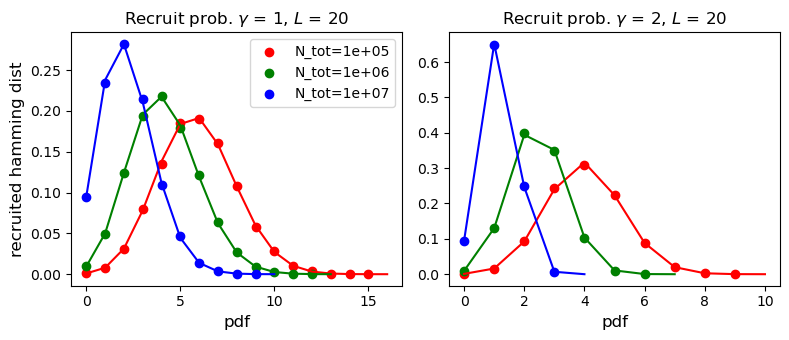

In [30]:
all_hs1, all_hs2 = [], []
for i, N_tot in enumerate(N_tots):
    aux1, aux2 = [], []
    for r in range(R):
        aux1.extend(h_recruit_post1[r][i])
        aux2.extend(h_recruit_post2[r][i])
    all_hs1.append(aux1)
    all_hs2.append(aux2)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))
colors = ['r', 'g', 'b']

ax1.set_title(r'Recruit prob. $\gamma$ = 1, $L$ = %.i'%L)
ax1.set_xlabel('pdf', fontsize=12)
ax1.set_ylabel('recruited hamming dist', fontsize=12)

for i, N_tot in enumerate(N_tots):
    h_uni1, h_count1 = np.unique(all_hs1[i], return_counts=True)
    h=ax1.scatter(h_uni1, h_count1/h_count1.sum(), label=f'N_tot=%.g'%N_tot, c=colors[i])
    hs = np.arange(max(h_uni1)+2)
    ps = w_pass(hs, D0s1[i], L, 1)
    ps /= ps.sum()
    ax1.plot(hs, ps, c=colors[i])
    
#ax1.legend(loc=2)

ax2.set_title(r'Recruit prob. $\gamma$ = 2, $L$ = %.i'%L)
ax2.set_xlabel('pdf', fontsize=12)
#ax1.set_ylabel('recruited hamming dist', fontsize=12)
for i, N_tot in enumerate(N_tots):
    h_uni2, h_count2 = np.unique(all_hs2[i], return_counts=True)
    h=ax2.scatter(h_uni2, h_count2/h_count2.sum(), label=f'N_tot=%.g'%N_tot, c=colors[i])
    hs = np.arange(max(h_uni2)+2)
    ps = w_pass(hs, D0s2[i], L, 2)
    ps /= ps.sum()
    ax2.plot(hs, ps, c=colors[i])

ax1.legend(loc=0)

plt.tight_layout()
plt.savefig(f'plots/evo_model/test_h_recruit_num_L={L}.svg', facecolor='w')

In [35]:
np.mean(all_hs1[0]), np.std(all_hs1[0]), mean_std_h_pass(D0s1[0], L,1)

(np.float64(5.8672242812781725),
 np.float64(2.038851965680184),
 (np.float64(5.874624553772456), np.float64(2.036925102055338)))

In [45]:
def get_logtau(hs, av_logtau=-4.0, std_logtau=2.5):
    mean, std = mean_std_h_pass(D0s1[0], L,1)
    b = std_logtau / std
    a = av_logtau - b*mean
    return a + b*np.array(hs, dtype=float)

In [46]:
logtaus = get_logtau(all_hs1[0])

1.227340169492438
-11.210162695531524


In [49]:
np.mean(logtaus), np.std(logtaus)

(np.float64(-4.009082651697424), np.float64(2.5023649171279074))